<h1 class="text-center"> Deep Sets – 06/01/2019 </h1>

<div class="jumbotron text-center"><b>Le but de ce notebook est de présenter les Deep Sets</b></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
import torch.nn.functional as F

<p class="bg-primary" style="padding:1em"><strong>QUESTION 0.0.</strong>  <br/> 
Dans ces encarts vous trouverez les questions auxquelles vous devez répondre. <br/>
 &#9679; Dans quels encarts faut-il répondre aux questions ? <br/>
 &#9679; Comment sauter une ligne ? 
</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION 0.0.</strong> <br>
&#9679; Il faut répondre dans ces encarts aux questions. Ils seront indiqués tout au long du Notebook <br>    
&#9679; Pour sauter une ligne il suffit d'écrire br entre <> à la fin de la ligne. <br>
</div>

# I. Présentation

## Introduction 

Les tâches de machine learning sont définies traditionnellement pour opérer sur : <br> 
&#9679; Des vecteurs de dimension fixée. <em> (Détection d'avions sur des images satellites 256*256) </em> <br>
&#9679; Sur des données où l'ordre importe <em> (Dans l'exemple de classification de mails, le mot "bonheur" est différent de "bhoneur".) </em> <br>
<br/>
Les "Deep Sets", ensembles profonds, sont une architecture qui nous permet de s'intéresser à des tâches de Machine Learning où les données d'entrée sont des ensembles, c'est à dire : <br>
&#9679; La dimension n'est pas fixée <br>
&#9679; L'ordre n'a pas d'importance <br>
On note par exemple que ces deux ensembles sont les mêmes : $U = \begin{Bmatrix} 1 ; 2; 3; 3 \end{Bmatrix}$ et $V = \begin{Bmatrix} 1 ; 3; 2\end{Bmatrix}$ <br> <br>
<strong> Propriété : </strong>
Les deux propriétés à noter pour un ensemble sont : <br>
&#9679; L'ordre ne revêt pas d'importance $\begin{Bmatrix} 1 ; 3\end{Bmatrix} = \begin{Bmatrix} 3; 1\end{Bmatrix}$<br>
&#9679; La répétition d'éléments entre les accolades ne modifie pas l'ensemble $\begin{Bmatrix} 1; 1; 1; 3\end{Bmatrix} = \begin{Bmatrix} 1; 3\end{Bmatrix}$ <br><br>

Pour un problème de classification on a : 
<img src="img/training_data.png" width="400"> 
<br>
Où chaque patatoïde est un ensemble et une entrée pour notre tâche d'apprentissage. A leur gauche on a leur label, classe. On remarque que ces ensembles n'ont pas forcément le même nombre d'éléments.

<div class="alert alert-success"> <strong> "Mais je ne comprends pas l'intérêt, nos mails ne faisaient pas tous la même taille, pourtant on a réussi à les traiter !!" </strong> <br> <br>
Pour traiter cette exemple, nous transformions notre mail en un vecteur ligne de taille 14279 <strong> fixe </strong> où chacune des 14279 colonnes représentaient un mot. Et pour chaque colonne du mail on remplissait la fréquence d'apparition du mot. <br>
</div>

Voici un premier exemple d'utilisation de Deep Sets, cependant nous savons déjà le traiter. En quoi cela peut-il vraiment nous être utile ? <br>

## Un exemple d'utilisation

Comment faire si on veut apprendre à un réseau de neurones à faire la somme d'un ensemble de chiffres fournis en entrée à partir des données MNIST ? <br>
<img src="img/sum_example.png" width="400">

On veut que le même réseau de neurones soit capable de faire cette opération. C'est pourquoi nous avons besoin de cette architecture que sont ces DeepSets.

# II. Un peu de théorie

## Les propriétés des fonctions à estimer
Comme vu précédemment, on a vu qu'une des propriétés de la fonction que l'on souhaite estimer est que l'ordre de ses entrées ne doit pas avoir d'importance. C'est à dire, ne pas avoir d'impact sur le résultat. <br>
On veut qu'à un même ensemble notre réseau de neurones renvoie le même résultat.  <br>
<img src="img/canard.png" width="200">

<p class="bg-primary" style="padding:1em"><strong>QUESTION II.1.</strong>  <br/> 
Citez deux fonctions qui prennent en entrée des ensembles. Une première qui renvoie un nombre, une seconde qui renvoie un ensemble. 
</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION II.1.</strong> <br>
VOTRE RÉPONSE ICI
</div>

<div class="alert alert-danger"><a href="#answer1" data-toggle="collapse">**Voir une réponse possible** </a><br>
<div id="answer1" class="collapse">
La fonction qui à chaque ensemble associe son cardinal, le nombre d'éléments dans cet ensemble. <br>
La fonction qui a un ensemble associe son intersection avec l'ensemble $U = \begin{Bmatrix} 1 ; 2 \end{Bmatrix}$
</div>
</div>

Dans le cas où notre sortie est un vecteur, deux propriétés sont à considérer. 
## L'invariance par permutation et l'équivariance par permutation :

<ul>
<li> L'invariance par permutation : La permutation des éléments de l'ensemble d'entrée n'affecte pas la sortie.
<li> L'équivariance par permutation : La permutation des éléments de l'ensemble d'entrée permute de la même manière les éléments de l'ensemble de sortie.
</ul>
<img src="img/permutation-invariance.png" width="800">
On se concentrera alors uniquement sur des fonctions où notre vecteur de sortie est un nombre. <br>
Autrement dit, uniquement sur la propriété d'invariance par permutation.

### II.A. Invariance par permutation

#### II.A.1 Le théorème central
<strong> Théorème : </strong> 
Une fonction $f(X)$ sur un ensemble $X$ d'éléments d'un univers dénombrable est invariante par permutation des instances dans X si et seulement si elle peut s'écrire de la forme : 
\begin{equation*}
    f(X) = \rho \begin{pmatrix} \Sigma_{x \in X} \Phi(x) \end{pmatrix}
\end{equation*}
où $\rho$ et $\Phi$ sont des transformations adéquates. Elles sont obtenues par entraînement, selon leur tâche spécifique. <br>

Ce résultat théorique nous apprend qu'il faudra alors apprendre deux fonctions. La fonction $\Phi$ et la fonction $\rho$. <br> 
Ce qui est important à retenir et qui nous permet de passer la difficulté du traitement d'un ensemble est qu'on effectue la somme des $\Phi(x)$

#### II.A.2 Mise en oeuvre

Supposons qu'on ait un ensemble $X = \begin{Bmatrix} x_m\end{Bmatrix}_{m \in I\subset \mathbb{N}}$ 
Chaque élément $x_m$ de l'ensemble $X$ est transformé en $\Phi(x_m)$. <br>
Tous les $\Phi(x_m)$ calculés, sont sommés. Nous avons alors : $\Sigma_{m \in I} \Phi(x_m)$  <br>
L'image de cette somme par $\rho$ est alors la sortie attendue. 

<img src="img/architecture_deep_sets.png" width="400">

Les fonctions $\Phi$ et $\rho$ seront traduites en un réseau de neurones.

#### II.A.3 Diverses applications

&#9678; Pouvoir travailler directement sur des ensembles d'objets. <br>
&#9678; Estimation de statistique sur une population. La population doit être vue comme un ensemble. <br>
&#9678; Des problèmes de régression, comme un problème de cosmologie, celui du décalage vers le rouge [Redshift - Wikipedia](https://fr.wikipedia.org/wiki/Décalage_vers_le_rouge) <br>


#### II.A.4 Une application sur un exemple

Il s'agit de l'exemple cité ci dessus "un exemple d'utilisation". <br>
Nous voulons avoir un réseau capable de trouver la somme des chiffres écrits à la main disposés dans un sac. Sans connaître par avance, le nombre de chiffres dans le sac. <br>
Nos entrées seront alors des ensembles d'images de tailles variées. La sortie sera la valeur de la somme des chiffres contenus dans l'ensemble. <br>
Les ensembles X cités ci-dessus sont alors nos ensembles d'images et chaque $x_m$ est une image. 

### II.B. Équivariance par permutation

Pour ce résultat on se restreint aux fonctions $f$ à estimer étant une couche d'un réseau de neurones. C'est à dire de la forme $f_{\Theta}(x) = \sigma(\Theta x)$ où $\Theta \in \mathbb{R}^{MxM}$ est la matrice des poids et $\sigma$ une fonctione non linéaire, telle la sigmoïde. <br>
On a alors ce théorème, qui est en fait un lemme du théorème précédent.
#### II.B.1 Le théorème central
<strong> Théorème : </strong> 
$f_{\Theta} : \mathbb{R}^{M} \rightarrow \mathbb{R}^{M}$ est équivariante par permutation si et seulement si tous les éléments diagonaux sont égaux entre eux et que les éléments non diagonaux sont aussi égaux. C'est à dire si : <br>
$\Theta = \lambda I + \gamma J$ où $I$ est la matrice identité et $J$ la matrice qui vaut 1 partout.

##### II.B.1.a En image

Les liens de la même couleur représente le même poids : <br> 
À gauche un "Perceptron multicouche" Multi Layer Perceptron et à droite l'architecture deepsets équivariante par permutation. 

<img src="img/nn-equiv.png" width="400">

##### II.B.1.b Petit éclairage

Notons que dans ce cas on a : $f(x) = \sigma(\lambda x + \gamma Jx)$. <br> 
Analysons le terme $\lambda x + \gamma Jx$. <br>
$\lambda x$ est clairement équivariant par permutation. Maintenant, $Jx$ : <br>
$Jx = \begin{pmatrix} x_1 + x_2 + ... +x_m \\
x_1 + x_2 + ... +x_m \\
... \\
x_1 + x_2 + ... +x_m \\\end{pmatrix}$ <br> 
Remarquons alors que $\lambda x + \gamma Jx$ est une combinaison linéaire entre l'entrée et la somme des valeurs de l'entrée. La somme des composantes de l'entrée est clairement invariante par permutation. <br>
Ainsi on note que $\lambda x + \gamma Jx$ est équivariant par permutation. 

#### II.B.2 Une propriété 
<strong> Propriété : </strong> 
La fonction composée de deux fonctions équivariantes par permutations reste équivariante par permutation.

<p class="bg-primary" style="padding:1em"><strong>QUESTION II.2.</strong>  <br/> 
Montrez la propriété sur la composée de deux fonctions équivariantes.
</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION II.2.</strong> <br>
VOTRE RÉPONSE ICI
</div>

<div class="alert alert-danger"><a href="#answer2" data-toggle="collapse">**Voir une réponse possible** </a><br>
<div id="answer2" class="collapse">
Soient $f,g$ deux fonctions équivariantes par permutations. <br>
On note $h = f \circ g$. <br>
Soit $\pi$ une permutation. <br>
\begin{equation*}
    \begin{aligned}
    h(\pi (x)) &= f(g(\pi(x))) \\
    &= f(\pi(g(x))) \\
    &= \pi(f(g(x))) \\
    &= \pi(h(x))
    \end{aligned}
\end{equation*}
</div>
</div>

#### II.B.3 Mise en oeuvre

Ainsi, notre réseau de neurones profonds sera la composée de plusieurs couches de cette forme. On sera alors assuré qu'il est équivariant.


#### II.B.4 Diverses applications

&#9678; La probabilité qu'un client achète un produit dans un ensemble donné à son prochain passage dans un magasin. <br>
&#9678; Des problèmes où il y a beaucoup d'invariances par symétries ou rotations. Ces problèmes sont en général inefficacement traités par les outils de Machine Learning. Prévoir la dynamique d'un ensemble de disques par exemple.

# III. L'invariance par permutation

## III.A Travail préliminaire

Nous allons utiliser [PyTorch](https://pytorch.org/docs/stable/index.html). <br>
<strong> Rappel : </strong> Un tenseur est un tableau multi-dimensionnel. <br>
À l'aide de Compose on echaîne des transformations d'image. <br>
On en enchaîne 2 : <br>
<ul>
<li> ToTensor() : transforme l'image en Tenseur
<li> Normalize(mean, std) : normalise une image tenseur à l'aide de la moyenne et de l'écart-type.
</ul>

In [2]:
from torch import FloatTensor
from torchvision.transforms import Compose, ToTensor, Normalize
MNIST_TRANSFORM = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

Téléchargeons les données que nous connaissons, les données MNIST et appliquons nos transformations.

In [3]:
from torch.utils.data.dataset import Dataset
from torchvision.datasets import MNIST
path = "../datasets/"
mnist = MNIST(path, train=True, transform=MNIST_TRANSFORM, download=True)

### Génération du Training Set

Travaillons dans un premier temps avec des ensembles qui contiennent entre 2 et 10 objets. <br>
Nous initialisons un certain nombre, dataset_len, d'ensembles.

In [4]:
dataset_len = 10000
# Nombre d'images MNIST chargé
mnist_len = mnist.__len__()
# Ensemble des indices des images chargées
mnist_items_range = np.arange(0, mnist_len)

In [5]:
# Les cardinaux des ensembles correspondant à chaque donnée d'entrée.
# On les choisit entre 2 et 10 éléments.
items_train_len_range = np.arange(2, 10 + 1)
items_train_len = np.random.choice(items_train_len_range, dataset_len, replace=True)
# Chaque élément de la liste mnist_items correspond à un ensemble d'images.
mnist_items_train = []
for i in range(dataset_len):
    mnist_items_train.append(np.random.choice(mnist_items_range, size=items_train_len[i], replace=True))

### Génération du Test Set

<p class="bg-primary" style="padding:1em"><strong>QUESTION III.1.</strong>  <br/> 
De la même manière que ci-dessus, générer le Test Set avec le même nombre de données mais où chaque exemple contient entre 5 et 50 images
</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION III.1.</strong> <br>
Votre réponse ci-dessous.
</div>

In [6]:
# %load solutions/code1.py
items_test_len_range = np.arange(5, 50 + 1)
items_test_len = np.random.choice(items_test_len_range, dataset_len, replace=True)
mnist_items_test = []
for i in range(dataset_len):
    mnist_items_test.append(np.random.choice(mnist_items_range, size=items_test_len[i], replace=True))

### Outils

In [79]:
def get_item(dataset, id_item):
    input_set = dataset[id_item]
    the_sum = 0
    images = []
    for mi in input_set:
        img, target = mnist.__getitem__(mi)
        the_sum += target
        images.append(img)
    return torch.stack(images, dim=0), torch.FloatTensor([the_sum])
'''
    À utiliser de préférence avec le train set.
'''
def plot_set(dataset, id_item):
    images_set, targ = get_item(dataset, id_item)
    fig = plt.figure()
    fig.suptitle("Sum: {}".format(targ.numpy()[0]))
    for i in range(images_set.shape[0]):
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        plt.imshow(images_set[i][0], cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])
    plt.show()

### Familiarisation avec les Tenseurs

In [8]:
set_img, target_sum = get_item(mnist_items_train, 0) 
print(set_img.shape)
print("Il y a : \n" + str(set_img.shape[0]) + " images dans l'ensemble n°0." 
      + " \nLe format est images est : " + str(set_img.shape[1:])
     + " \nLe 1 correspond à l'échelle de gris et le 28x28 à la taille des images")
print(set_img.shape[1:])

torch.Size([9, 1, 28, 28])
Il y a : 
9 images dans l'ensemble n°0. 
Le format est images est : torch.Size([1, 28, 28]) 
Le 1 correspond à l'échelle de gris et le 28x28 à la taille des images
torch.Size([1, 28, 28])


### Affichage d'un ensemble de la base d'entraînement

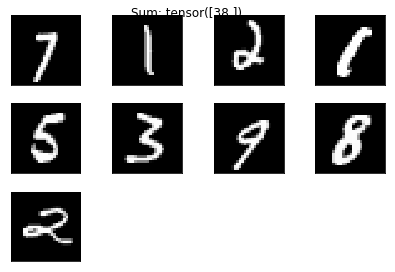

In [9]:
plot_set(mnist_items_train, 0)

# IV. Création de notre réseau

## Création de $\Phi$ et $\rho$

Définissons nos 2 sous-réseaux ($\Phi$ et $\rho$) de neurones, que notre modèle final englobera. <br>
On définit d'abord nos différentes couches, puis on définit la propagation. <br>

In [10]:
class Phi(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc1_drop = nn.Dropout2d()
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc1_drop(x)
        x = self.fc2(x)
        x = F.relu(x)
        return x

<p class="bg-primary" style="padding:1em"><strong>QUESTION IV.1.</strong>  <br/> 
Définir la classe de la fonction $\rho$. <br>
Elle comportera deux couches totalement connectées ("Fully Connected") et une fonction d'activation relu.
</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION IV.1.</strong> <br>
Votre réponse ci-dessous.
</div>

In [11]:
# %load solutions/code2.py
class Rho(nn.Module):
    def __init__(self, input_size, output_size = 1):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.fc1 = nn.Linear(self.input_size, 10)
        self.fc2 = nn.Linear(10, self.output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## Modèle final

Maintenant on peut définir le modèle pour une fonction invariante par permutation.

In [55]:
class InvariantModel(nn.Module):
    def __init__(self, phi, rho):
        super().__init__()
        self.phi = phi
        self.rho = rho

    def forward(self, x):
        # Calcule l'image par la fonction $\Phi$ pour chaque image
        x = self.phi.forward(x)
        # On fait la somme de ce qu'on vient de calculer et on oublie la difficulté de l'ensemble.
        x = torch.sum(x, dim=0, keepdim=True)
        # compute the output
        out = self.rho.forward(x)
        return out

## Entraînement

On mesure notre erreur d'entraînement grâce à l'erreur quadratique moyenne (MSE).

In [72]:
n_epochs = 100
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*dataset_len for i in range(n_epochs + 1)]

In [73]:
phi = Phi()
rho = Rho(10, 1)
network = InvariantModel(phi, rho)
optimizer = optim.Adam(network.parameters(), lr=1e-3, weight_decay=5e-3)

In [74]:
def train_item(id_item):
    X, target = get_item(mnist_items_train, id_item)
    X = Variable(X)
    target = Variable(target)
    optimizer.zero_grad()
    pred = network.forward(X)
    the_loss = F.mse_loss(pred, target)
    the_loss.backward()
    optimizer.step()
    the_loss_tensor = the_loss.data
    the_loss_numpy = the_loss_tensor.numpy().flatten()
    the_loss_float = float(the_loss_numpy[0])
    return the_loss_float

def train(epoch):
    network.train()
    loss = 0
    for i in tqdm(range(dataset_len)):
        loss += train_item(i)
    train_losses.append(loss/dataset_len)
    train_counter.append(epoch)

In [77]:
def evaluate():
    network.eval()
    totals = [0] * 51
    corrects = [0] * 51
    loss = 0
    for id_item in tqdm(range(dataset_len)):
        X, target = get_item(mnist_items_test, id_item)
        item_size = X.shape[0]
        pred = network.forward(Variable(X)).data
        loss += float(F.mse_loss(pred, target).data.numpy().flatten()[0])
        pred = int(round(float(pred[0])))
        target = int(round(float(target.numpy()[0])))
    return loss/dataset_len

In [78]:
for i in range(5):
    train(i)
    mse_test = evaluate()
    test_losses.append(mse_test)




  0%|          | 0/10000 [00:00<?, ?it/s]


  0%|          | 10/10000 [00:00<01:41, 98.88it/s]


  0%|          | 22/10000 [00:00<01:35, 103.96it/s]


  0%|          | 33/10000 [00:00<01:35, 104.75it/s]


  0%|          | 45/10000 [00:00<01:31, 108.39it/s]


  1%|          | 57/10000 [00:00<01:29, 110.74it/s]


  1%|          | 70/10000 [00:00<01:26, 115.05it/s]


  1%|          | 83/10000 [00:00<01:23, 118.28it/s]


  1%|          | 97/10000 [00:00<01:21, 121.90it/s]


  1%|          | 110/10000 [00:00<01:20, 123.58it/s]


  1%|          | 123/10000 [00:01<01:18, 125.25it/s]


  1%|▏         | 136/10000 [00:01<01:19, 123.97it/s]


  1%|▏         | 149/10000 [00:01<01:22, 119.62it/s]


  2%|▏         | 161/10000 [00:01<01:29, 110.02it/s]


  2%|▏         | 173/10000 [00:01<01:28, 111.26it/s]


  2%|▏         | 188/10000 [00:01<01:22, 118.79it/s]


  2%|▏         | 202/10000 [00:01<01:19, 123.33it/s]


  2%|▏         | 216/10000 [00:01<01:17, 126.78it/s]


  2%|▏         | 229/10000 

 32%|███▏      | 3196/10000 [00:30<01:19, 85.80it/s]


 32%|███▏      | 3207/10000 [00:30<01:14, 91.30it/s]


 32%|███▏      | 3218/10000 [00:30<01:11, 95.26it/s]


 32%|███▏      | 3231/10000 [00:31<01:05, 103.05it/s]


 32%|███▏      | 3242/10000 [00:31<01:05, 103.74it/s]


 33%|███▎      | 3253/10000 [00:31<01:04, 104.70it/s]


 33%|███▎      | 3266/10000 [00:31<01:01, 109.09it/s]


 33%|███▎      | 3279/10000 [00:31<00:58, 114.22it/s]


 33%|███▎      | 3291/10000 [00:31<00:59, 112.67it/s]


 33%|███▎      | 3305/10000 [00:31<00:56, 118.98it/s]


 33%|███▎      | 3318/10000 [00:31<00:57, 115.75it/s]


 33%|███▎      | 3333/10000 [00:31<00:54, 123.35it/s]


 33%|███▎      | 3346/10000 [00:32<00:55, 119.59it/s]


 34%|███▎      | 3361/10000 [00:32<00:52, 125.66it/s]


 34%|███▎      | 3374/10000 [00:32<00:54, 121.78it/s]


 34%|███▍      | 3387/10000 [00:32<01:01, 107.53it/s]


 34%|███▍      | 3399/10000 [00:32<01:02, 105.96it/s]


 34%|███▍      | 3410/10000 [00:32<01:04, 102.33it/

 65%|██████▌   | 6516/10000 [00:59<00:26, 130.22it/s]


 65%|██████▌   | 6530/10000 [00:59<00:26, 130.28it/s]


 65%|██████▌   | 6545/10000 [00:59<00:25, 135.57it/s]


 66%|██████▌   | 6560/10000 [00:59<00:24, 138.29it/s]


 66%|██████▌   | 6575/10000 [00:59<00:24, 140.89it/s]


 66%|██████▌   | 6591/10000 [00:59<00:23, 144.80it/s]


 66%|██████▌   | 6607/10000 [00:59<00:22, 148.51it/s]


 66%|██████▌   | 6623/10000 [00:59<00:22, 149.28it/s]


 66%|██████▋   | 6638/10000 [01:00<00:22, 149.04it/s]


 67%|██████▋   | 6654/10000 [01:00<00:22, 151.02it/s]


 67%|██████▋   | 6670/10000 [01:00<00:21, 152.76it/s]


 67%|██████▋   | 6686/10000 [01:00<00:22, 148.68it/s]


 67%|██████▋   | 6701/10000 [01:00<00:22, 148.96it/s]


 67%|██████▋   | 6716/10000 [01:00<00:22, 147.14it/s]


 67%|██████▋   | 6731/10000 [01:00<00:22, 144.20it/s]


 67%|██████▋   | 6746/10000 [01:00<00:22, 144.86it/s]


 68%|██████▊   | 6763/10000 [01:00<00:21, 149.44it/s]


 68%|██████▊   | 6778/10000 [01:01<00:21, 148.70

 80%|████████  | 8047/10000 [01:13<00:16, 117.33it/s]


 81%|████████  | 8059/10000 [01:14<00:17, 113.90it/s]


 81%|████████  | 8071/10000 [01:14<00:17, 112.48it/s]


 81%|████████  | 8084/10000 [01:14<00:16, 116.90it/s]


 81%|████████  | 8097/10000 [01:14<00:15, 119.33it/s]


 81%|████████  | 8110/10000 [01:14<00:16, 116.94it/s]


 81%|████████  | 8122/10000 [01:14<00:19, 97.22it/s] 


 81%|████████▏ | 8134/10000 [01:14<00:18, 101.28it/s]


 81%|████████▏ | 8145/10000 [01:14<00:18, 102.17it/s]


 82%|████████▏ | 8156/10000 [01:15<00:22, 81.81it/s] 


 82%|████████▏ | 8166/10000 [01:15<00:24, 75.41it/s]


 82%|████████▏ | 8176/10000 [01:15<00:22, 81.16it/s]


 82%|████████▏ | 8190/10000 [01:15<00:19, 92.21it/s]


 82%|████████▏ | 8201/10000 [01:15<00:19, 92.24it/s]


 82%|████████▏ | 8211/10000 [01:15<00:22, 81.10it/s]


 82%|████████▏ | 8223/10000 [01:15<00:19, 89.02it/s]


 82%|████████▏ | 8236/10000 [01:15<00:18, 97.84it/s]


 82%|████████▏ | 8249/10000 [01:15<00:16, 105.29it/s]



  7%|▋         | 697/10000 [00:13<02:55, 52.94it/s]


  7%|▋         | 705/10000 [00:13<02:38, 58.53it/s]


  7%|▋         | 712/10000 [00:13<02:32, 61.01it/s]


  7%|▋         | 720/10000 [00:13<02:22, 65.16it/s]


  7%|▋         | 727/10000 [00:13<02:26, 63.26it/s]


  7%|▋         | 734/10000 [00:14<02:32, 60.58it/s]


  7%|▋         | 742/10000 [00:14<02:24, 64.24it/s]


  8%|▊         | 752/10000 [00:14<02:14, 68.78it/s]


  8%|▊         | 762/10000 [00:14<02:02, 75.32it/s]


  8%|▊         | 770/10000 [00:14<02:01, 76.03it/s]


  8%|▊         | 780/10000 [00:14<01:54, 80.50it/s]


  8%|▊         | 789/10000 [00:14<01:55, 80.08it/s]


  8%|▊         | 799/10000 [00:14<01:48, 84.74it/s]


  8%|▊         | 808/10000 [00:14<01:48, 85.10it/s]


  8%|▊         | 820/10000 [00:15<01:41, 90.81it/s]


  8%|▊         | 830/10000 [00:15<01:43, 88.52it/s]


  8%|▊         | 840/10000 [00:15<01:41, 90.42it/s]


  8%|▊         | 850/10000 [00:15<01:58, 77.52it/s]


  9%|▊         | 859/10000 [

 26%|██▋       | 2625/10000 [00:44<01:54, 64.13it/s]


 26%|██▋       | 2632/10000 [00:45<01:55, 63.64it/s]


 26%|██▋       | 2639/10000 [00:45<02:18, 53.25it/s]


 26%|██▋       | 2646/10000 [00:45<02:10, 56.34it/s]


 27%|██▋       | 2654/10000 [00:45<01:59, 61.36it/s]


 27%|██▋       | 2664/10000 [00:45<01:48, 67.53it/s]


 27%|██▋       | 2672/10000 [00:45<02:40, 45.74it/s]


 27%|██▋       | 2678/10000 [00:46<03:18, 36.82it/s]


 27%|██▋       | 2684/10000 [00:46<02:57, 41.30it/s]


 27%|██▋       | 2691/10000 [00:46<02:40, 45.47it/s]


 27%|██▋       | 2700/10000 [00:46<02:19, 52.40it/s]


 27%|██▋       | 2707/10000 [00:46<02:10, 56.02it/s]


 27%|██▋       | 2714/10000 [00:46<02:05, 58.18it/s]


 27%|██▋       | 2721/10000 [00:46<02:04, 58.50it/s]


 27%|██▋       | 2728/10000 [00:46<02:04, 58.24it/s]


 27%|██▋       | 2736/10000 [00:46<01:56, 62.49it/s]


 27%|██▋       | 2744/10000 [00:47<01:53, 64.09it/s]


 28%|██▊       | 2751/10000 [00:47<01:51, 64.92it/s]


 28%|██▊  

 48%|████▊     | 4797/10000 [01:15<01:32, 56.01it/s]


 48%|████▊     | 4804/10000 [01:15<01:45, 49.09it/s]


 48%|████▊     | 4810/10000 [01:15<01:58, 43.92it/s]


 48%|████▊     | 4816/10000 [01:15<02:02, 42.24it/s]


 48%|████▊     | 4821/10000 [01:15<02:08, 40.32it/s]


 48%|████▊     | 4826/10000 [01:15<02:10, 39.72it/s]


 48%|████▊     | 4831/10000 [01:15<02:08, 40.31it/s]


 48%|████▊     | 4836/10000 [01:16<02:11, 39.32it/s]


 48%|████▊     | 4841/10000 [01:16<02:12, 38.85it/s]


 48%|████▊     | 4847/10000 [01:16<01:59, 42.98it/s]


 49%|████▊     | 4853/10000 [01:16<01:57, 43.84it/s]


 49%|████▊     | 4858/10000 [01:16<02:03, 41.62it/s]


 49%|████▊     | 4866/10000 [01:16<01:47, 47.97it/s]


 49%|████▉     | 4876/10000 [01:16<01:30, 56.66it/s]


 49%|████▉     | 4887/10000 [01:16<01:17, 66.25it/s]


 49%|████▉     | 4896/10000 [01:17<01:12, 70.78it/s]


 49%|████▉     | 4905/10000 [01:17<01:07, 75.44it/s]


 49%|████▉     | 4914/10000 [01:17<01:05, 77.21it/s]


 49%|████▉

 70%|███████   | 7002/10000 [01:45<00:35, 84.58it/s]


 70%|███████   | 7011/10000 [01:45<00:37, 79.86it/s]


 70%|███████   | 7023/10000 [01:45<00:34, 86.88it/s]


 70%|███████   | 7032/10000 [01:45<00:34, 86.00it/s]


 70%|███████   | 7043/10000 [01:45<00:33, 89.32it/s]


 71%|███████   | 7053/10000 [01:45<00:33, 88.57it/s]


 71%|███████   | 7062/10000 [01:45<00:34, 85.26it/s]


 71%|███████   | 7071/10000 [01:46<00:34, 85.72it/s]


 71%|███████   | 7080/10000 [01:46<00:35, 81.45it/s]


 71%|███████   | 7091/10000 [01:46<00:34, 85.03it/s]


 71%|███████   | 7100/10000 [01:46<00:34, 84.69it/s]


 71%|███████   | 7109/10000 [01:46<00:33, 85.06it/s]


 71%|███████   | 7118/10000 [01:46<00:33, 86.22it/s]


 71%|███████▏  | 7127/10000 [01:46<00:33, 86.17it/s]


 71%|███████▏  | 7136/10000 [01:46<00:33, 86.38it/s]


 71%|███████▏  | 7145/10000 [01:46<00:32, 86.72it/s]


 72%|███████▏  | 7154/10000 [01:47<00:32, 87.39it/s]


 72%|███████▏  | 7163/10000 [01:47<00:32, 87.96it/s]


 72%|█████

 95%|█████████▍| 9478/10000 [02:14<00:05, 87.13it/s]


 95%|█████████▍| 9487/10000 [02:14<00:06, 79.31it/s]


 95%|█████████▍| 9496/10000 [02:14<00:06, 79.71it/s]


 95%|█████████▌| 9508/10000 [02:14<00:05, 88.00it/s]


 95%|█████████▌| 9518/10000 [02:14<00:05, 86.30it/s]


 95%|█████████▌| 9527/10000 [02:14<00:05, 82.96it/s]


 95%|█████████▌| 9537/10000 [02:14<00:05, 86.75it/s]


 95%|█████████▌| 9548/10000 [02:14<00:04, 92.32it/s]


 96%|█████████▌| 9558/10000 [02:14<00:04, 92.11it/s]


 96%|█████████▌| 9569/10000 [02:15<00:04, 95.63it/s]


 96%|█████████▌| 9579/10000 [02:15<00:04, 91.51it/s]


 96%|█████████▌| 9589/10000 [02:15<00:04, 88.10it/s]


 96%|█████████▌| 9598/10000 [02:15<00:04, 86.33it/s]


 96%|█████████▌| 9607/10000 [02:15<00:04, 82.83it/s]


 96%|█████████▌| 9618/10000 [02:15<00:04, 87.46it/s]


 96%|█████████▋| 9627/10000 [02:15<00:04, 87.46it/s]


 96%|█████████▋| 9636/10000 [02:15<00:04, 87.97it/s]


 96%|█████████▋| 9647/10000 [02:15<00:03, 90.19it/s]


 97%|█████

 28%|██▊       | 2829/10000 [00:21<00:53, 135.09it/s]


 28%|██▊       | 2844/10000 [00:21<00:51, 138.47it/s]


 29%|██▊       | 2860/10000 [00:21<00:49, 144.15it/s]


 29%|██▉       | 2875/10000 [00:21<00:49, 144.34it/s]


 29%|██▉       | 2890/10000 [00:21<00:49, 143.49it/s]


 29%|██▉       | 2905/10000 [00:21<00:49, 142.96it/s]


 29%|██▉       | 2921/10000 [00:21<00:48, 146.94it/s]


 29%|██▉       | 2936/10000 [00:22<00:48, 144.55it/s]


 30%|██▉       | 2951/10000 [00:22<00:49, 143.63it/s]


 30%|██▉       | 2966/10000 [00:22<00:49, 142.61it/s]


 30%|██▉       | 2981/10000 [00:22<00:49, 142.34it/s]


 30%|██▉       | 2996/10000 [00:22<00:49, 142.91it/s]


 30%|███       | 3011/10000 [00:22<00:49, 140.02it/s]


 30%|███       | 3026/10000 [00:22<00:50, 138.81it/s]


 30%|███       | 3041/10000 [00:22<00:49, 141.10it/s]


 31%|███       | 3056/10000 [00:22<00:50, 138.56it/s]


 31%|███       | 3073/10000 [00:22<00:48, 144.18it/s]


 31%|███       | 3088/10000 [00:23<00:48, 141.52

 65%|██████▍   | 6452/10000 [00:48<00:42, 83.59it/s]


 65%|██████▍   | 6461/10000 [00:48<00:42, 84.02it/s]


 65%|██████▍   | 6470/10000 [00:48<00:43, 81.13it/s]


 65%|██████▍   | 6479/10000 [00:48<00:43, 80.08it/s]


 65%|██████▍   | 6488/10000 [00:48<00:44, 79.07it/s]


 65%|██████▍   | 6496/10000 [00:48<00:44, 78.43it/s]


 65%|██████▌   | 6504/10000 [00:49<00:47, 74.16it/s]


 65%|██████▌   | 6516/10000 [00:49<00:41, 83.03it/s]


 65%|██████▌   | 6530/10000 [00:49<00:37, 93.53it/s]


 65%|██████▌   | 6544/10000 [00:49<00:33, 102.19it/s]


 66%|██████▌   | 6555/10000 [00:49<00:38, 89.87it/s] 


 66%|██████▌   | 6565/10000 [00:49<00:41, 82.29it/s]


 66%|██████▌   | 6576/10000 [00:49<00:38, 88.47it/s]


 66%|██████▌   | 6586/10000 [00:49<00:42, 80.25it/s]


 66%|██████▌   | 6595/10000 [00:50<00:43, 77.87it/s]


 66%|██████▌   | 6604/10000 [00:50<00:43, 78.85it/s]


 66%|██████▌   | 6613/10000 [00:50<00:43, 77.39it/s]


 66%|██████▌   | 6622/10000 [00:50<00:42, 78.92it/s]


 66%|███

  1%|          | 83/10000 [00:00<01:50, 89.40it/s]


  1%|          | 95/10000 [00:01<01:43, 96.00it/s]


  1%|          | 105/10000 [00:01<01:42, 96.99it/s]


  1%|          | 116/10000 [00:01<01:39, 99.42it/s]


  1%|▏         | 128/10000 [00:01<01:35, 102.97it/s]


  1%|▏         | 141/10000 [00:01<01:30, 109.18it/s]


  2%|▏         | 153/10000 [00:01<01:30, 108.47it/s]


  2%|▏         | 164/10000 [00:01<01:36, 101.62it/s]


  2%|▏         | 179/10000 [00:01<01:28, 111.31it/s]


  2%|▏         | 191/10000 [00:01<01:28, 110.29it/s]


  2%|▏         | 203/10000 [00:02<01:27, 112.02it/s]


  2%|▏         | 215/10000 [00:02<01:30, 107.74it/s]


  2%|▏         | 226/10000 [00:02<01:32, 105.67it/s]


  2%|▏         | 237/10000 [00:02<01:34, 103.26it/s]


  2%|▏         | 248/10000 [00:02<01:36, 100.74it/s]


  3%|▎         | 261/10000 [00:02<01:30, 107.65it/s]


  3%|▎         | 272/10000 [00:02<01:36, 100.77it/s]


  3%|▎         | 285/10000 [00:02<01:30, 107.52it/s]


  3%|▎         |

 29%|██▉       | 2900/10000 [00:29<01:05, 108.28it/s]


 29%|██▉       | 2911/10000 [00:29<01:11, 99.51it/s] 


 29%|██▉       | 2922/10000 [00:29<01:12, 97.74it/s]


 29%|██▉       | 2932/10000 [00:29<01:17, 91.49it/s]


 29%|██▉       | 2942/10000 [00:30<01:16, 92.36it/s]


 30%|██▉       | 2954/10000 [00:30<01:11, 98.89it/s]


 30%|██▉       | 2966/10000 [00:30<01:09, 101.91it/s]


 30%|██▉       | 2977/10000 [00:30<01:11, 98.28it/s] 


 30%|██▉       | 2987/10000 [00:30<01:13, 95.85it/s]


 30%|██▉       | 2999/10000 [00:30<01:09, 101.09it/s]


 30%|███       | 3010/10000 [00:30<01:09, 99.89it/s] 


 30%|███       | 3022/10000 [00:30<01:08, 101.86it/s]


 30%|███       | 3033/10000 [00:30<01:08, 102.00it/s]


 30%|███       | 3044/10000 [00:31<01:08, 100.87it/s]


 31%|███       | 3056/10000 [00:31<01:05, 105.46it/s]


 31%|███       | 3069/10000 [00:31<01:02, 111.09it/s]


 31%|███       | 3081/10000 [00:31<01:05, 105.96it/s]


 31%|███       | 3094/10000 [00:31<01:01, 112.18it/s]

 58%|█████▊    | 5768/10000 [00:57<00:44, 94.42it/s]


 58%|█████▊    | 5779/10000 [00:57<00:43, 95.93it/s]


 58%|█████▊    | 5790/10000 [00:57<00:42, 99.33it/s]


 58%|█████▊    | 5801/10000 [00:57<00:42, 99.31it/s]


 58%|█████▊    | 5812/10000 [00:58<00:41, 102.07it/s]


 58%|█████▊    | 5823/10000 [00:58<00:41, 99.69it/s] 


 58%|█████▊    | 5834/10000 [00:58<00:41, 100.68it/s]


 58%|█████▊    | 5845/10000 [00:58<00:42, 98.76it/s] 


 59%|█████▊    | 5857/10000 [00:58<00:40, 101.92it/s]


 59%|█████▊    | 5868/10000 [00:58<00:39, 103.58it/s]


 59%|█████▉    | 5879/10000 [00:58<00:39, 103.03it/s]


 59%|█████▉    | 5890/10000 [00:58<00:43, 95.49it/s] 


 59%|█████▉    | 5902/10000 [00:58<00:40, 101.23it/s]


 59%|█████▉    | 5913/10000 [00:59<00:40, 101.06it/s]


 59%|█████▉    | 5924/10000 [00:59<00:41, 98.34it/s] 


 59%|█████▉    | 5935/10000 [00:59<00:40, 100.48it/s]


 59%|█████▉    | 5947/10000 [00:59<00:39, 103.83it/s]


 60%|█████▉    | 5959/10000 [00:59<00:37, 107.73it/s

 86%|████████▌ | 8613/10000 [01:25<00:13, 106.45it/s]


 86%|████████▌ | 8624/10000 [01:25<00:12, 106.74it/s]


 86%|████████▋ | 8635/10000 [01:25<00:13, 102.18it/s]


 86%|████████▋ | 8646/10000 [01:25<00:13, 102.92it/s]


 87%|████████▋ | 8658/10000 [01:25<00:12, 105.69it/s]


 87%|████████▋ | 8669/10000 [01:26<00:13, 101.50it/s]


 87%|████████▋ | 8681/10000 [01:26<00:12, 103.57it/s]


 87%|████████▋ | 8692/10000 [01:26<00:13, 97.62it/s] 


 87%|████████▋ | 8706/10000 [01:26<00:12, 105.27it/s]


 87%|████████▋ | 8718/10000 [01:26<00:12, 106.81it/s]


 87%|████████▋ | 8730/10000 [01:26<00:11, 109.54it/s]


 87%|████████▋ | 8742/10000 [01:26<00:11, 106.28it/s]


 88%|████████▊ | 8753/10000 [01:26<00:11, 106.45it/s]


 88%|████████▊ | 8767/10000 [01:26<00:10, 113.07it/s]


 88%|████████▊ | 8779/10000 [01:27<00:10, 111.28it/s]


 88%|████████▊ | 8792/10000 [01:27<00:10, 114.99it/s]


 88%|████████▊ | 8804/10000 [01:27<00:10, 108.91it/s]


 88%|████████▊ | 8816/10000 [01:27<00:10, 108.11

 20%|██        | 2016/10000 [00:14<00:52, 150.83it/s]


 20%|██        | 2032/10000 [00:14<00:55, 143.92it/s]


 20%|██        | 2049/10000 [00:14<00:53, 149.72it/s]


 21%|██        | 2065/10000 [00:14<00:51, 152.60it/s]


 21%|██        | 2082/10000 [00:14<00:50, 156.79it/s]


 21%|██        | 2098/10000 [00:14<00:50, 156.71it/s]


 21%|██        | 2114/10000 [00:14<00:53, 148.16it/s]


 21%|██▏       | 2129/10000 [00:14<00:53, 146.17it/s]


 21%|██▏       | 2144/10000 [00:14<00:53, 146.41it/s]


 22%|██▏       | 2159/10000 [00:15<00:54, 144.67it/s]


 22%|██▏       | 2175/10000 [00:15<00:53, 146.11it/s]


 22%|██▏       | 2192/10000 [00:15<00:51, 151.09it/s]


 22%|██▏       | 2210/10000 [00:15<00:49, 158.72it/s]


 22%|██▏       | 2227/10000 [00:15<00:50, 153.71it/s]


 22%|██▏       | 2246/10000 [00:15<00:48, 161.14it/s]


 23%|██▎       | 2263/10000 [00:15<00:48, 159.81it/s]


 23%|██▎       | 2280/10000 [00:15<00:48, 159.70it/s]


 23%|██▎       | 2297/10000 [00:15<00:49, 156.95

 61%|██████    | 6071/10000 [00:40<00:25, 154.66it/s]


 61%|██████    | 6087/10000 [00:40<00:26, 150.08it/s]


 61%|██████    | 6103/10000 [00:40<00:26, 147.84it/s]


 61%|██████    | 6119/10000 [00:41<00:25, 150.98it/s]


 61%|██████▏   | 6135/10000 [00:41<00:25, 149.05it/s]


 62%|██████▏   | 6151/10000 [00:41<00:25, 149.04it/s]


 62%|██████▏   | 6167/10000 [00:41<00:25, 149.71it/s]


 62%|██████▏   | 6183/10000 [00:41<00:25, 151.92it/s]


 62%|██████▏   | 6199/10000 [00:41<00:25, 149.16it/s]


 62%|██████▏   | 6217/10000 [00:41<00:24, 157.08it/s]


 62%|██████▏   | 6233/10000 [00:41<00:24, 154.69it/s]


 62%|██████▏   | 6249/10000 [00:41<00:24, 154.83it/s]


 63%|██████▎   | 6266/10000 [00:42<00:23, 158.14it/s]


 63%|██████▎   | 6282/10000 [00:42<00:24, 154.45it/s]


 63%|██████▎   | 6299/10000 [00:42<00:23, 156.94it/s]


 63%|██████▎   | 6315/10000 [00:42<00:24, 151.71it/s]


 63%|██████▎   | 6331/10000 [00:42<00:24, 148.42it/s]


 63%|██████▎   | 6347/10000 [00:42<00:24, 150.56

  1%|          | 69/10000 [00:00<01:45, 93.78it/s]


  1%|          | 81/10000 [00:00<01:39, 99.24it/s]


  1%|          | 96/10000 [00:00<01:30, 109.68it/s]


  1%|          | 108/10000 [00:01<01:30, 108.89it/s]


  1%|          | 123/10000 [00:01<01:24, 116.58it/s]


  1%|▏         | 136/10000 [00:01<01:23, 118.74it/s]


  1%|▏         | 149/10000 [00:01<01:22, 119.13it/s]


  2%|▏         | 162/10000 [00:01<01:24, 116.22it/s]


  2%|▏         | 178/10000 [00:01<01:18, 124.96it/s]


  2%|▏         | 191/10000 [00:01<01:19, 123.74it/s]


  2%|▏         | 204/10000 [00:01<01:19, 123.04it/s]


  2%|▏         | 217/10000 [00:01<01:20, 120.87it/s]


  2%|▏         | 230/10000 [00:02<01:24, 115.33it/s]


  2%|▏         | 242/10000 [00:02<01:24, 116.15it/s]


  3%|▎         | 254/10000 [00:02<01:23, 116.58it/s]


  3%|▎         | 267/10000 [00:02<01:21, 120.13it/s]


  3%|▎         | 280/10000 [00:02<01:24, 115.44it/s]


  3%|▎         | 292/10000 [00:02<01:23, 116.19it/s]


  3%|▎         

 33%|███▎      | 3287/10000 [00:28<01:00, 110.34it/s]


 33%|███▎      | 3299/10000 [00:28<01:04, 103.76it/s]


 33%|███▎      | 3311/10000 [00:28<01:02, 107.24it/s]


 33%|███▎      | 3322/10000 [00:28<01:01, 107.81it/s]


 33%|███▎      | 3334/10000 [00:28<01:01, 109.20it/s]


 33%|███▎      | 3347/10000 [00:29<00:58, 113.08it/s]


 34%|███▎      | 3360/10000 [00:29<00:56, 117.26it/s]


 34%|███▎      | 3372/10000 [00:29<00:57, 114.43it/s]


 34%|███▍      | 3384/10000 [00:29<00:57, 115.88it/s]


 34%|███▍      | 3396/10000 [00:29<00:58, 112.49it/s]


 34%|███▍      | 3410/10000 [00:29<00:56, 116.62it/s]


 34%|███▍      | 3423/10000 [00:29<00:55, 119.40it/s]


 34%|███▍      | 3438/10000 [00:29<00:51, 126.73it/s]


 35%|███▍      | 3451/10000 [00:29<00:53, 121.63it/s]


 35%|███▍      | 3464/10000 [00:30<00:56, 115.81it/s]


 35%|███▍      | 3476/10000 [00:30<00:55, 116.88it/s]


 35%|███▍      | 3488/10000 [00:30<00:58, 110.90it/s]


 35%|███▌      | 3501/10000 [00:30<00:57, 112.53

 65%|██████▍   | 6465/10000 [00:56<00:30, 114.20it/s]


 65%|██████▍   | 6477/10000 [00:56<00:32, 108.44it/s]


 65%|██████▍   | 6490/10000 [00:56<00:30, 113.63it/s]


 65%|██████▌   | 6502/10000 [00:56<00:30, 114.10it/s]


 65%|██████▌   | 6517/10000 [00:56<00:28, 121.67it/s]


 65%|██████▌   | 6531/10000 [00:56<00:27, 124.46it/s]


 65%|██████▌   | 6544/10000 [00:56<00:28, 122.01it/s]


 66%|██████▌   | 6557/10000 [00:57<00:27, 123.16it/s]


 66%|██████▌   | 6571/10000 [00:57<00:26, 127.63it/s]


 66%|██████▌   | 6584/10000 [00:57<00:26, 127.31it/s]


 66%|██████▌   | 6599/10000 [00:57<00:25, 133.02it/s]


 66%|██████▌   | 6613/10000 [00:57<00:28, 118.49it/s]


 66%|██████▋   | 6626/10000 [00:57<00:31, 105.60it/s]


 66%|██████▋   | 6638/10000 [00:57<00:31, 105.38it/s]


 67%|██████▋   | 6651/10000 [00:57<00:30, 111.61it/s]


 67%|██████▋   | 6664/10000 [00:57<00:28, 115.24it/s]


 67%|██████▋   | 6676/10000 [00:58<00:28, 116.20it/s]


 67%|██████▋   | 6688/10000 [00:58<00:30, 108.89

 96%|█████████▋| 9635/10000 [01:24<00:03, 110.22it/s]


 96%|█████████▋| 9647/10000 [01:24<00:03, 110.92it/s]


 97%|█████████▋| 9660/10000 [01:24<00:02, 114.61it/s]


 97%|█████████▋| 9674/10000 [01:24<00:02, 121.07it/s]


 97%|█████████▋| 9687/10000 [01:24<00:02, 122.70it/s]


 97%|█████████▋| 9700/10000 [01:24<00:02, 123.25it/s]


 97%|█████████▋| 9716/10000 [01:24<00:02, 131.92it/s]


 97%|█████████▋| 9730/10000 [01:24<00:02, 126.98it/s]


 97%|█████████▋| 9743/10000 [01:24<00:02, 121.11it/s]


 98%|█████████▊| 9756/10000 [01:25<00:02, 117.49it/s]


 98%|█████████▊| 9769/10000 [01:25<00:01, 119.69it/s]


 98%|█████████▊| 9782/10000 [01:25<00:01, 122.60it/s]


 98%|█████████▊| 9795/10000 [01:25<00:01, 121.29it/s]


 98%|█████████▊| 9808/10000 [01:25<00:01, 118.26it/s]


 98%|█████████▊| 9821/10000 [01:25<00:01, 119.06it/s]


 98%|█████████▊| 9833/10000 [01:25<00:01, 114.10it/s]


 98%|█████████▊| 9845/10000 [01:25<00:01, 111.49it/s]


 99%|█████████▊| 9857/10000 [01:25<00:01, 110.96

 36%|███▌      | 3577/10000 [00:23<00:45, 140.60it/s]


 36%|███▌      | 3593/10000 [00:23<00:44, 145.22it/s]


 36%|███▌      | 3608/10000 [00:23<00:44, 143.17it/s]


 36%|███▌      | 3623/10000 [00:24<00:45, 139.88it/s]


 36%|███▋      | 3638/10000 [00:24<00:44, 141.44it/s]


 37%|███▋      | 3654/10000 [00:24<00:44, 144.18it/s]


 37%|███▋      | 3669/10000 [00:24<00:43, 144.07it/s]


 37%|███▋      | 3684/10000 [00:24<00:43, 143.58it/s]


 37%|███▋      | 3699/10000 [00:24<00:44, 141.51it/s]


 37%|███▋      | 3714/10000 [00:24<00:44, 139.94it/s]


 37%|███▋      | 3729/10000 [00:24<00:44, 141.52it/s]


 37%|███▋      | 3745/10000 [00:24<00:42, 145.49it/s]


 38%|███▊      | 3760/10000 [00:25<00:43, 144.98it/s]


 38%|███▊      | 3776/10000 [00:25<00:42, 147.45it/s]


 38%|███▊      | 3792/10000 [00:25<00:41, 149.64it/s]


 38%|███▊      | 3808/10000 [00:25<00:41, 150.94it/s]


 38%|███▊      | 3824/10000 [00:25<00:40, 150.82it/s]


 38%|███▊      | 3842/10000 [00:25<00:39, 157.23

 75%|███████▍  | 7451/10000 [00:50<00:18, 139.92it/s]


 75%|███████▍  | 7466/10000 [00:50<00:18, 140.56it/s]


 75%|███████▍  | 7481/10000 [00:50<00:17, 141.32it/s]


 75%|███████▍  | 7496/10000 [00:50<00:17, 143.49it/s]


 75%|███████▌  | 7511/10000 [00:51<00:17, 140.53it/s]


 75%|███████▌  | 7526/10000 [00:51<00:18, 136.95it/s]


 75%|███████▌  | 7541/10000 [00:51<00:17, 137.02it/s]


 76%|███████▌  | 7555/10000 [00:51<00:18, 134.46it/s]


 76%|███████▌  | 7569/10000 [00:51<00:18, 135.03it/s]


 76%|███████▌  | 7583/10000 [00:51<00:18, 129.89it/s]


 76%|███████▌  | 7597/10000 [00:51<00:18, 132.39it/s]


 76%|███████▌  | 7611/10000 [00:51<00:18, 131.45it/s]


 76%|███████▋  | 7625/10000 [00:51<00:18, 128.07it/s]


 76%|███████▋  | 7639/10000 [00:51<00:18, 129.95it/s]


 77%|███████▋  | 7654/10000 [00:52<00:17, 134.93it/s]


 77%|███████▋  | 7668/10000 [00:52<00:17, 135.30it/s]


 77%|███████▋  | 7682/10000 [00:52<00:17, 135.04it/s]


 77%|███████▋  | 7697/10000 [00:52<00:16, 139.17

 10%|█         | 1028/10000 [00:09<01:24, 106.72it/s]


 10%|█         | 1039/10000 [00:09<01:24, 106.42it/s]


 11%|█         | 1052/10000 [00:09<01:20, 110.98it/s]


 11%|█         | 1067/10000 [00:09<01:14, 119.24it/s]


 11%|█         | 1080/10000 [00:09<01:18, 113.85it/s]


 11%|█         | 1092/10000 [00:09<01:20, 110.76it/s]


 11%|█         | 1104/10000 [00:09<01:19, 112.57it/s]


 11%|█         | 1118/10000 [00:09<01:15, 118.30it/s]


 11%|█▏        | 1131/10000 [00:10<01:16, 116.36it/s]


 11%|█▏        | 1143/10000 [00:10<01:18, 113.10it/s]


 12%|█▏        | 1155/10000 [00:10<01:19, 111.10it/s]


 12%|█▏        | 1167/10000 [00:10<01:21, 108.56it/s]


 12%|█▏        | 1178/10000 [00:10<01:22, 107.11it/s]


 12%|█▏        | 1191/10000 [00:10<01:19, 110.71it/s]


 12%|█▏        | 1203/10000 [00:10<01:17, 113.12it/s]


 12%|█▏        | 1215/10000 [00:10<01:16, 114.36it/s]


 12%|█▏        | 1229/10000 [00:10<01:12, 120.84it/s]


 12%|█▏        | 1242/10000 [00:11<01:15, 115.37

 42%|████▏     | 4237/10000 [00:36<00:51, 112.78it/s]


 43%|████▎     | 4252/10000 [00:37<00:47, 120.84it/s]


 43%|████▎     | 4265/10000 [00:37<00:47, 119.99it/s]


 43%|████▎     | 4278/10000 [00:37<00:48, 116.89it/s]


 43%|████▎     | 4292/10000 [00:37<00:46, 122.68it/s]


 43%|████▎     | 4305/10000 [00:37<00:50, 111.83it/s]


 43%|████▎     | 4317/10000 [00:37<00:50, 112.95it/s]


 43%|████▎     | 4329/10000 [00:37<00:49, 114.10it/s]


 43%|████▎     | 4341/10000 [00:37<00:50, 112.19it/s]


 44%|████▎     | 4353/10000 [00:37<00:49, 113.53it/s]


 44%|████▎     | 4366/10000 [00:38<00:47, 117.41it/s]


 44%|████▍     | 4378/10000 [00:38<00:48, 115.76it/s]


 44%|████▍     | 4391/10000 [00:38<00:47, 117.17it/s]


 44%|████▍     | 4404/10000 [00:38<00:47, 118.21it/s]


 44%|████▍     | 4416/10000 [00:38<00:49, 111.79it/s]


 44%|████▍     | 4429/10000 [00:38<00:48, 115.08it/s]


 44%|████▍     | 4441/10000 [00:38<00:48, 115.80it/s]


 45%|████▍     | 4453/10000 [00:38<00:50, 110.91

 74%|███████▍  | 7415/10000 [01:04<00:23, 108.62it/s]


 74%|███████▍  | 7427/10000 [01:04<00:23, 110.52it/s]


 74%|███████▍  | 7442/10000 [01:04<00:21, 119.16it/s]


 75%|███████▍  | 7455/10000 [01:04<00:21, 116.95it/s]


 75%|███████▍  | 7467/10000 [01:05<00:22, 113.19it/s]


 75%|███████▍  | 7479/10000 [01:05<00:21, 114.88it/s]


 75%|███████▍  | 7493/10000 [01:05<00:21, 118.27it/s]


 75%|███████▌  | 7505/10000 [01:05<00:21, 117.52it/s]


 75%|███████▌  | 7517/10000 [01:05<00:21, 116.16it/s]


 75%|███████▌  | 7531/10000 [01:05<00:20, 121.39it/s]


 75%|███████▌  | 7544/10000 [01:05<00:20, 117.25it/s]


 76%|███████▌  | 7557/10000 [01:05<00:20, 118.76it/s]


 76%|███████▌  | 7570/10000 [01:05<00:20, 121.26it/s]


 76%|███████▌  | 7583/10000 [01:05<00:19, 122.64it/s]


 76%|███████▌  | 7596/10000 [01:06<00:19, 123.80it/s]


 76%|███████▌  | 7609/10000 [01:06<00:19, 125.13it/s]


 76%|███████▌  | 7622/10000 [01:06<00:19, 124.62it/s]


 76%|███████▋  | 7635/10000 [01:06<00:20, 115.88

  8%|▊         | 750/10000 [00:05<01:02, 148.24it/s]


  8%|▊         | 765/10000 [00:05<01:02, 146.88it/s]


  8%|▊         | 780/10000 [00:05<01:03, 146.18it/s]


  8%|▊         | 796/10000 [00:05<01:01, 149.71it/s]


  8%|▊         | 813/10000 [00:05<00:59, 154.05it/s]


  8%|▊         | 829/10000 [00:05<00:58, 155.46it/s]


  8%|▊         | 845/10000 [00:05<00:58, 156.72it/s]


  9%|▊         | 861/10000 [00:05<01:00, 150.91it/s]


  9%|▉         | 877/10000 [00:05<00:59, 153.36it/s]


  9%|▉         | 894/10000 [00:05<00:57, 157.14it/s]


  9%|▉         | 910/10000 [00:06<00:58, 155.84it/s]


  9%|▉         | 927/10000 [00:06<00:57, 158.56it/s]


  9%|▉         | 943/10000 [00:06<00:57, 157.50it/s]


 10%|▉         | 959/10000 [00:06<00:57, 157.66it/s]


 10%|▉         | 975/10000 [00:06<00:57, 156.39it/s]


 10%|▉         | 992/10000 [00:06<00:57, 157.30it/s]


 10%|█         | 1009/10000 [00:06<00:56, 160.43it/s]


 10%|█         | 1026/10000 [00:06<00:57, 155.82it/s]


 10%|█  

 48%|████▊     | 4850/10000 [00:31<00:33, 154.43it/s]


 49%|████▊     | 4866/10000 [00:31<00:33, 154.81it/s]


 49%|████▉     | 4884/10000 [00:31<00:31, 160.17it/s]


 49%|████▉     | 4901/10000 [00:32<00:31, 160.23it/s]


 49%|████▉     | 4918/10000 [00:32<00:33, 153.66it/s]


 49%|████▉     | 4934/10000 [00:32<00:32, 154.74it/s]


 50%|████▉     | 4950/10000 [00:32<00:32, 153.29it/s]


 50%|████▉     | 4967/10000 [00:32<00:32, 156.19it/s]


 50%|████▉     | 4983/10000 [00:32<00:32, 155.45it/s]


 50%|████▉     | 4999/10000 [00:32<00:32, 154.84it/s]


 50%|█████     | 5015/10000 [00:32<00:32, 155.65it/s]


 50%|█████     | 5031/10000 [00:32<00:31, 155.76it/s]


 50%|█████     | 5047/10000 [00:32<00:31, 155.58it/s]


 51%|█████     | 5063/10000 [00:33<00:31, 155.60it/s]


 51%|█████     | 5079/10000 [00:33<00:32, 152.88it/s]


 51%|█████     | 5095/10000 [00:33<00:31, 153.59it/s]


 51%|█████     | 5111/10000 [00:33<00:31, 154.20it/s]


 51%|█████▏    | 5128/10000 [00:33<00:30, 158.51

 89%|████████▉ | 8901/10000 [00:58<00:07, 151.24it/s]


 89%|████████▉ | 8917/10000 [00:58<00:07, 151.50it/s]


 89%|████████▉ | 8933/10000 [00:58<00:07, 151.49it/s]


 89%|████████▉ | 8949/10000 [00:58<00:07, 149.82it/s]


 90%|████████▉ | 8965/10000 [00:58<00:06, 151.21it/s]


 90%|████████▉ | 8981/10000 [00:58<00:06, 148.46it/s]


 90%|████████▉ | 8998/10000 [00:58<00:06, 153.02it/s]


 90%|█████████ | 9014/10000 [00:59<00:06, 151.48it/s]


 90%|█████████ | 9031/10000 [00:59<00:06, 153.48it/s]


 90%|█████████ | 9047/10000 [00:59<00:06, 150.91it/s]


 91%|█████████ | 9064/10000 [00:59<00:06, 155.51it/s]


 91%|█████████ | 9081/10000 [00:59<00:05, 156.75it/s]


 91%|█████████ | 9098/10000 [00:59<00:05, 159.23it/s]


 91%|█████████ | 9114/10000 [00:59<00:05, 155.38it/s]


 91%|█████████▏| 9131/10000 [00:59<00:05, 159.04it/s]


 91%|█████████▏| 9147/10000 [00:59<00:05, 151.86it/s]


 92%|█████████▏| 9163/10000 [01:00<00:05, 152.55it/s]


 92%|█████████▏| 9179/10000 [01:00<00:05, 148.97

 23%|██▎       | 2301/10000 [00:20<01:09, 110.42it/s]


 23%|██▎       | 2313/10000 [00:20<01:09, 110.09it/s]


 23%|██▎       | 2328/10000 [00:20<01:04, 119.38it/s]


 23%|██▎       | 2343/10000 [00:20<01:00, 125.91it/s]


 24%|██▎       | 2356/10000 [00:20<01:03, 120.18it/s]


 24%|██▎       | 2370/10000 [00:20<01:01, 124.16it/s]


 24%|██▍       | 2386/10000 [00:20<00:57, 131.31it/s]


 24%|██▍       | 2400/10000 [00:20<01:02, 122.48it/s]


 24%|██▍       | 2413/10000 [00:21<01:02, 121.19it/s]


 24%|██▍       | 2428/10000 [00:21<00:59, 126.60it/s]


 24%|██▍       | 2443/10000 [00:21<00:57, 130.60it/s]


 25%|██▍       | 2457/10000 [00:21<00:57, 131.02it/s]


 25%|██▍       | 2471/10000 [00:21<00:56, 132.92it/s]


 25%|██▍       | 2485/10000 [00:21<01:00, 125.01it/s]


 25%|██▍       | 2498/10000 [00:21<00:59, 126.41it/s]


 25%|██▌       | 2511/10000 [00:21<00:58, 127.08it/s]


 25%|██▌       | 2524/10000 [00:21<00:58, 127.52it/s]


 25%|██▌       | 2538/10000 [00:22<00:57, 129.73

 54%|█████▍    | 5427/10000 [00:48<00:43, 104.01it/s]


 54%|█████▍    | 5439/10000 [00:48<00:42, 108.07it/s]


 55%|█████▍    | 5452/10000 [00:48<00:40, 112.42it/s]


 55%|█████▍    | 5464/10000 [00:48<00:39, 113.55it/s]


 55%|█████▍    | 5477/10000 [00:48<00:38, 117.34it/s]


 55%|█████▍    | 5493/10000 [00:48<00:35, 126.51it/s]


 55%|█████▌    | 5506/10000 [00:48<00:37, 121.09it/s]


 55%|█████▌    | 5519/10000 [00:48<00:37, 119.70it/s]


 55%|█████▌    | 5532/10000 [00:48<00:38, 115.23it/s]


 55%|█████▌    | 5545/10000 [00:49<00:37, 118.47it/s]


 56%|█████▌    | 5559/10000 [00:49<00:36, 122.69it/s]


 56%|█████▌    | 5572/10000 [00:49<00:37, 118.13it/s]


 56%|█████▌    | 5584/10000 [00:49<00:37, 118.43it/s]


 56%|█████▌    | 5598/10000 [00:49<00:35, 123.03it/s]


 56%|█████▌    | 5612/10000 [00:49<00:34, 127.49it/s]


 56%|█████▋    | 5627/10000 [00:49<00:33, 130.82it/s]


 56%|█████▋    | 5641/10000 [00:49<00:34, 125.21it/s]


 57%|█████▋    | 5655/10000 [00:49<00:33, 128.01

 86%|████████▌ | 8610/10000 [01:15<00:11, 117.25it/s]


 86%|████████▌ | 8622/10000 [01:15<00:11, 117.71it/s]


 86%|████████▋ | 8634/10000 [01:15<00:12, 113.23it/s]


 86%|████████▋ | 8647/10000 [01:16<00:11, 116.95it/s]


 87%|████████▋ | 8659/10000 [01:16<00:11, 116.41it/s]


 87%|████████▋ | 8671/10000 [01:16<00:11, 115.50it/s]


 87%|████████▋ | 8683/10000 [01:16<00:11, 116.06it/s]


 87%|████████▋ | 8695/10000 [01:16<00:11, 112.33it/s]


 87%|████████▋ | 8710/10000 [01:16<00:10, 118.81it/s]


 87%|████████▋ | 8724/10000 [01:16<00:10, 124.32it/s]


 87%|████████▋ | 8737/10000 [01:16<00:10, 120.53it/s]


 88%|████████▊ | 8750/10000 [01:16<00:10, 119.92it/s]


 88%|████████▊ | 8765/10000 [01:17<00:09, 125.91it/s]


 88%|████████▊ | 8778/10000 [01:17<00:09, 124.42it/s]


 88%|████████▊ | 8792/10000 [01:17<00:09, 128.59it/s]


 88%|████████▊ | 8805/10000 [01:17<00:09, 121.34it/s]


 88%|████████▊ | 8818/10000 [01:17<00:09, 122.00it/s]


 88%|████████▊ | 8831/10000 [01:17<00:09, 120.22

In [40]:
import os
cur_wd = os.getcwd()

In [80]:
PATH = cur_wd + "/models/10000data-5ep-bet.pt"
torch.save(network.state_dict(), PATH)
# Load a model
# model = torch.load(PATH)
# model.eval()

Text(0.5, 0, 'époque')

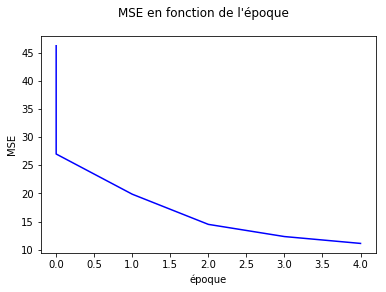

In [81]:
fig = plt.figure()
fig.suptitle("MSE en fonction de l'époque")
plt.ylabel('MSE')
plt.plot(train_counter, train_losses, color='blue')
plt.xlabel('époque')
#fig.savefig('plot10000data-5ep-bet.png')

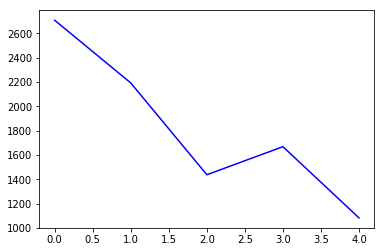

In [83]:
plt.plot(train_counter[1:], test_losses, color='blue')

In [ ]:
network2 = InvariantModel(phi, rho)
for i in range(1):
    train(network2)

# Bibliographie

[Article arxiv](https://arxiv.org/abs/1703.06114) by Manzil Zaheer, Satwik Kottur, Siamak Ravanbakhsh, Barnabas Poczos, Ruslan Salakhutdinov, Alexander Smola. <br/>

[Presentation during NIPS 2017 (video)](https://vimeo.com/252106503?fbclid=IwAR2WStzVVBqWtTRh7HiWFWsZRV-T9gkWH1a0mp2qGeu9jmnw3pXc6NbjEFk)  <br/>

[Summary of nips article about Deep Sets](https://tech.instacart.com/3-nips-papers-we-loved-befb39a75ec2) by [Jerem Stanley](https://tech.instacart.com/@jeremy.stanley). <br/>

[Various applications](https://indico.cern.ch/event/745718/contributions/3202523/attachments/1753843/2842746/PTK_ML4Jets_Fermilab_compressed.pdf?fbclid=IwAR0FCRnJ9rgK1T1vjaqtB0KfalkTjRmjwl3xy_IM93QX5wkH96fiTVZ4ItA) <br/>

[Deepsets implementation](https://github.com/yassersouri/pytorch-deep-sets?fbclid=IwAR1YbWX2Baejr7syYh1mikgafqhgSmBmIMf-EtU8HDziabuynoUhc3UvX5c) <br/>

[Hand digits recognition Pytorch](https://nextjournal.com/gkoehler/pytorch-mnist) <br>

[Permutation equivariant applied to dynamic predictions](https://arxiv.org/pdf/1612.04530.pdf)